# SBIPIX: Getting Started Tutorial

Welcome to SBIPIX! This tutorial will walk you through the complete workflow:

1. **Simulate** - Generate synthetic galaxy SEDs
2. **Train** - Train the normalizing flow model
3. **Test** - Evaluate model performance
4. **Load Real Data** - Import JADES observations
5. **Infer** - Run inference on real galaxies
6. **Visualize** - Create maps and posterior predictive checks

Let's get started! 🚀

## Prerequisites

Make sure you have SBIPIX installed:

```bash
pip install -e .
```

In [1]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
from sbipix import sbipix
import os

# Set up nice plotting
plt.style.use('default')
plt.rcParams['figure.figsize'] = (10, 6)

print("✅ Imports successful!")

/Users/patriglesias/Desktop/PhD/sedflow_JWST/CODE/SBIPIX/sbipix_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Starting dense_basis. please wait ~ a minute for the FSPS backend to initialize.
running without emcee
✅ Imports successful!


## Step 1: Initialize SBIPIX

First, let's create an SBIPIX instance and configure it for JADES data.

In [2]:
# Initialize SBIPIX
sx = sbipix()

# Configure for JADES survey
sx.filter_list = 'filters_jades_no_wfc.dat'
sx.atlas_name = 'atlas_obs_jades'
sx.n_simulation = 1000  # Start small for tutorial
sx.parametric = True    # Use τ-delayed star formation histories
sx.both_masses = True   # Infer both stellar and formed masses
sx.infer_z = False      # Use known redshifts

print("🔧 SBIPIX configured for JADES!")
print(f"   - Filters: {sx.filter_list}")
print(f"   - Simulations: {sx.n_simulation}")
print(f"   - Parametric SFH: {sx.parametric}")

🔧 SBIPIX configured for JADES!
   - Filters: filters_jades_no_wfc.dat
   - Simulations: 1000
   - Parametric SFH: True


## Step 2: Simulate Galaxy SEDs

Now we'll generate a library of synthetic galaxy spectra with realistic parameter ranges.

In [3]:
# Define parameter ranges for simulation
print("🌌 Simulating galaxy SEDs... This may take a while")

# Run simulation (this will take a few minutes)
sx.simulate(
    mass_max=12.0,      # log(M*/M☉) = 12 (very massive), formed
    mass_min=4.0,       # log(M*/M☉) = 4 (low mass), formed
    z_prior='flat',     # Uniform redshift prior
    z_min=0.0,          # Local universe
    z_max=7.5,          # High redshift
    Z_min=-2.27,        # Very metal poor
    Z_max=0.4,          # Super-solar metallicity
    dust_model='Calzetti',  # Dust attenuation law
    Av_min=0.0,         # No dust
    Av_max=4.0          # Heavy dust
)

print("✅ Simulation complete!")

🌌 Simulating galaxy SEDs... This may take a while
Generating parametric (τ-delayed) SFH atlas...
Generating atlas with:
N_pregrid: 1000, Parametric SFH (delayed-tau model)


Generating parametric SEDs:   0%|          | 0/1000 [00:23<?, ?it/s]


KeyboardInterrupt: 

In [7]:
# Load simulation results
sx.load_simulation()

print(f"📊 Simulation summary:")
print(f"   - Generated {len(sx.theta)} galaxy models")
print(f"   - Parameters shape: {sx.theta.shape}")
print(f"   - Photometry shape: {sx.obs.shape}")

# Quick look at parameter ranges
param_names = ['log(M*/M☉)', 'log(M*formed/M☉)', 'log(SFR)', 'τ [Gyr]', 'ti [Gyr]', '[M/H]', 'Av']
for i, name in enumerate(param_names):
    if i < sx.theta.shape[1]:
        print(f"   - {name}: [{sx.theta[:, i].min():.2f}, {sx.theta[:, i].max():.2f}]")


📊 Simulation summary:
   - Generated 1000 galaxy models
   - Parameters shape: (1000, 8)
   - Photometry shape: (1000, 19)
   - log(M*/M☉): [-21.21, 15.62]
   - log(M*formed/M☉): [-21.07, 15.86]
   - log(SFR): [-32.96, 3.86]
   - τ [Gyr]: [0.01, 98.51]
   - ti [Gyr]: [0.00, 11.15]
   - [M/H]: [-2.27, 0.40]
   - Av: [0.01, 4.00]


## Step 3: Add Observational Effects

Make the simulations realistic by adding noise, detection limits, and other observational effects.

In [8]:
# Add observational realism
print("🔭 Adding observational effects...")

sx.include_limit = True      # Include detection limits
sx.condition_sigma = True    # Condition on photometric uncertainties
sx.include_sigma = True      # Include sigma values as input

# Load observational properties
sx.load_obs_features()

# Add noise, NaNs, and detection limits
sx.add_noise_nan_limit_all()

print("✅ Observational effects added!")
print(f"   - Detection limits: {sx.include_limit}")
print(f"   - Photometric errors: {sx.include_sigma}")

🔭 Adding observational effects...
Observational features loaded


Adding observational realism: 100%|██████████| 1000/1000 [00:00<00:00, 32370.70it/s]

✅ Observational effects added!
   - Detection limits: True
   - Photometric errors: True


## Step 4: Clean Data and Train Model

Remove invalid data points and train the normalizing flow.

In [9]:
# Clean data - remove NaNs and infinities
print("🧹 Cleaning simulation data...")

sim_ok = np.isfinite(np.sum(sx.theta, axis=1))
print(f"   - Valid simulations: {np.sum(sim_ok)}/{len(sim_ok)} ({np.mean(sim_ok):.1%})")

sx.theta = sx.theta[sim_ok, :]
sx.mag = sx.mag[sim_ok, :, :]
sx.obs = sx.obs[sim_ok, :]
sx.n_simulation = len(sx.theta)

print(f"   - Final dataset: {sx.n_simulation} galaxies")

🧹 Cleaning simulation data...
   - Valid simulations: 1000/1000 (100.0%)
   - Final dataset: 1000 galaxies


In [10]:
# Calculate parameter bounds for normalization
max_thetas = np.max(sx.theta, axis=0)
min_thetas = np.min(sx.theta, axis=0)

print("📐 Parameter bounds:")
for i, name in enumerate(param_names):
    if i < len(min_thetas):
        print(f"   - {name}: [{min_thetas[i]:.2f}, {max_thetas[i]:.2f}]")

📐 Parameter bounds:
   - log(M*/M☉): [-21.21, 15.62]
   - log(M*formed/M☉): [-21.07, 15.86]
   - log(SFR): [-32.96, 3.86]
   - τ [Gyr]: [0.01, 98.51]
   - ti [Gyr]: [0.00, 11.15]
   - [M/H]: [-2.27, 0.40]
   - Av: [0.01, 4.00]


In [15]:
# Train the normalizing flow
print("🧠 Training normalizing flow model...")
print("   (This may take several minutes)")

sx.train(
    min_thetas=min_thetas,
    max_thetas=max_thetas,
    n_max=len(sx.theta),
    nblocks=5,          # Number of coupling blocks
    nhidden=128         # Hidden units per layer
)

print("✅ Training complete!")

🧠 Training normalizing flow model...
   (This may take several minutes)
 Neural network successfully converged after 218 epochs.
        -------------------------
        ||||| ROUND 1 STATS |||||:
        -------------------------
        Epochs trained: 218
        Best validation performance: 7.7501
        -------------------------
        
Model saved to ./library/posteriors.pkl
✅ Training complete!


## Step 5: Test Model Performance

Evaluate how well our trained model can recover known parameters.

**Note:** This model is not great! For better performance increase size of the simulation or use the pretrained model (post_obs_jades_resolved_tau_z7.5_cpu.pkl; with $\tau$-delayed SFHs)

#sx.model="post_obs_jades_resolved_tau_z7.5_cpu.pkl"

In [3]:
sx.model="post_obs_jades_resolved_tau_z7.5_cpu.pkl"

In [11]:
# Test model performance

#sx.model="post_obs_jades_resolved_tau_z7.5_cpu.pkl"
print("📊 Testing model performance...")

posterior_test = sx.test_performance(
    n_test=50,              # Test on 50 galaxies
    return_posterior=True   # Return full posterior samples
)

print("✅ Performance test complete!")
print(f"   - Tested on {posterior_test.shape[0]} galaxies")
print(f"   - Posterior shape: {posterior_test.shape}")

📊 Testing model performance...


Testing performance: 100%|██████████| 50/50 [00:00<00:00, 69.18it/s]

✅ Performance test complete!
   - Tested on 50 galaxies
   - Posterior shape: (50, 100, 7)


📈 Plotting performance diagnostics...


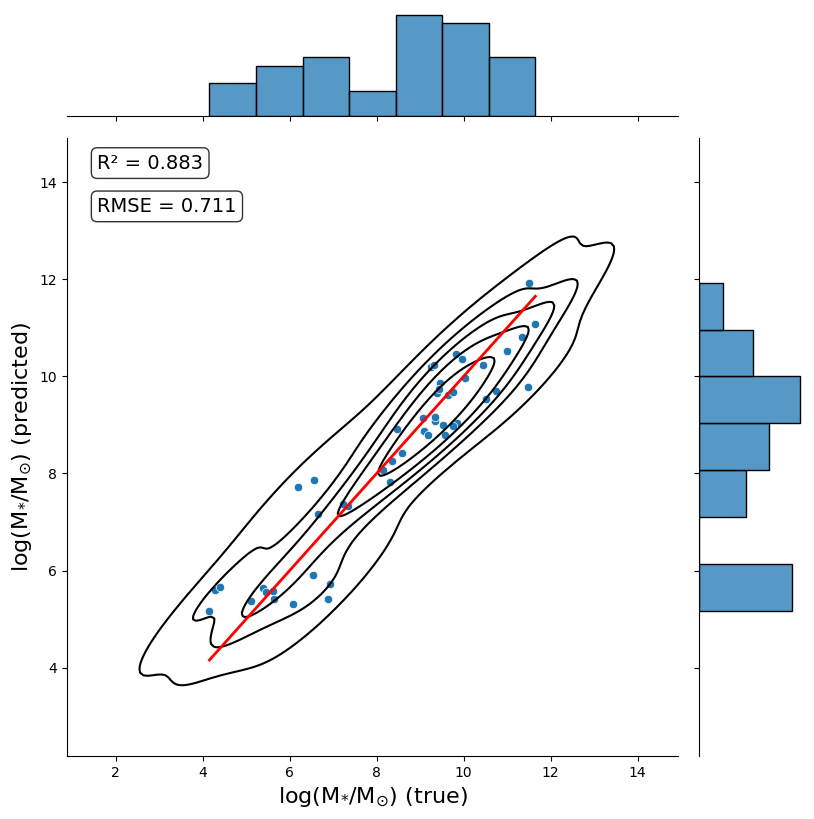

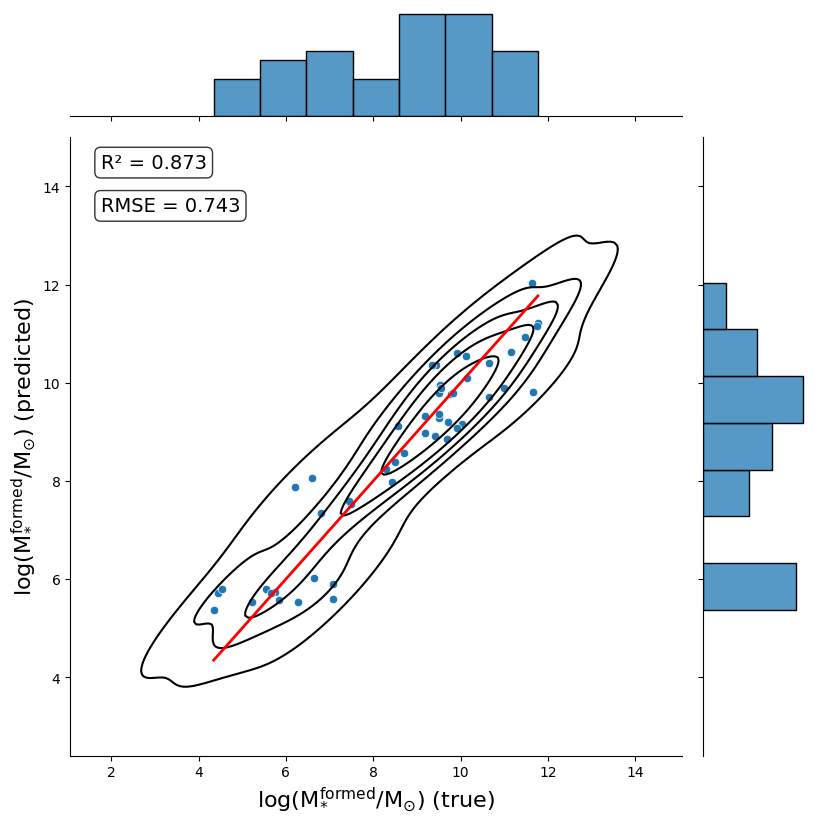

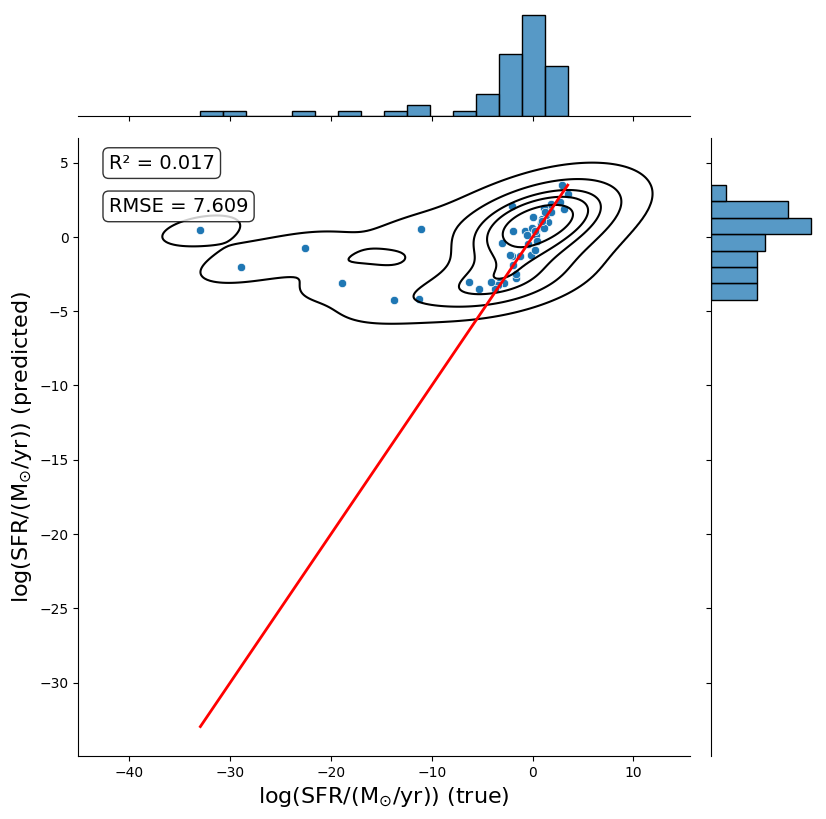

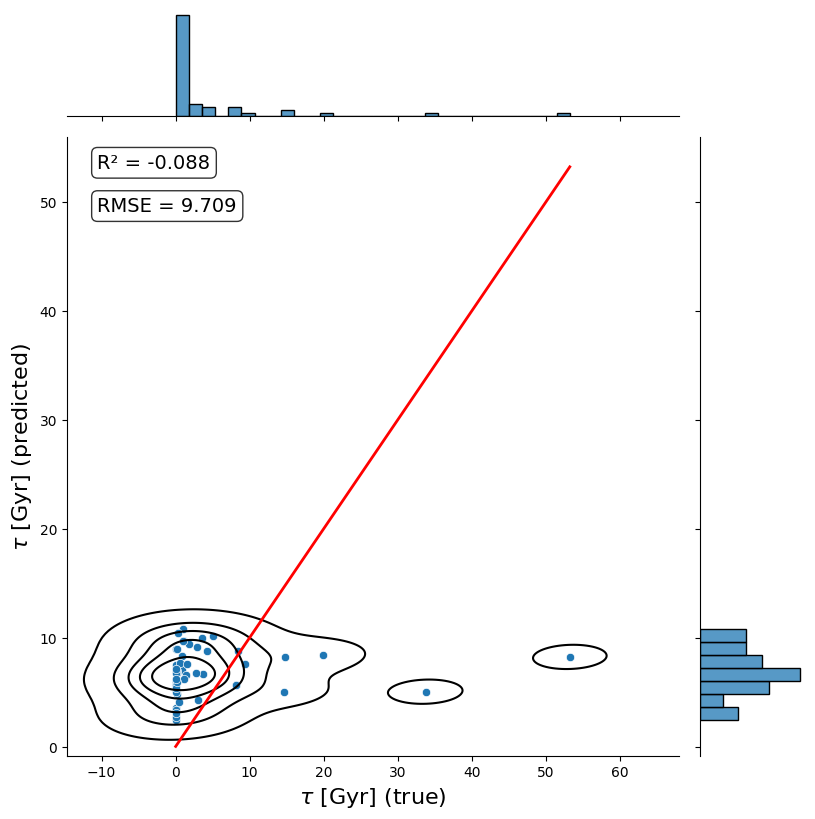

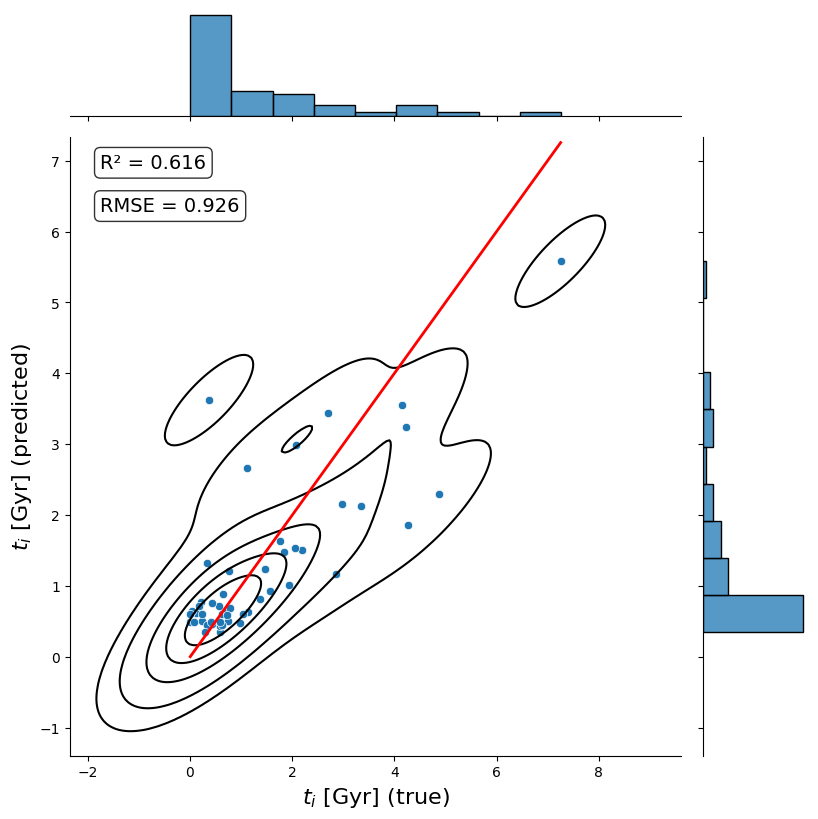

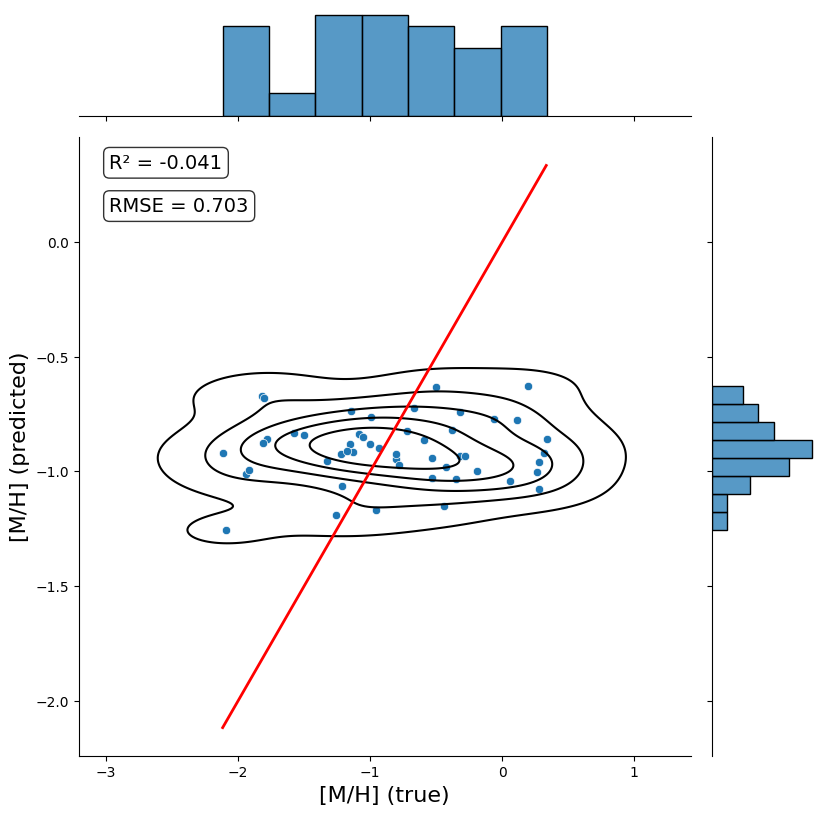

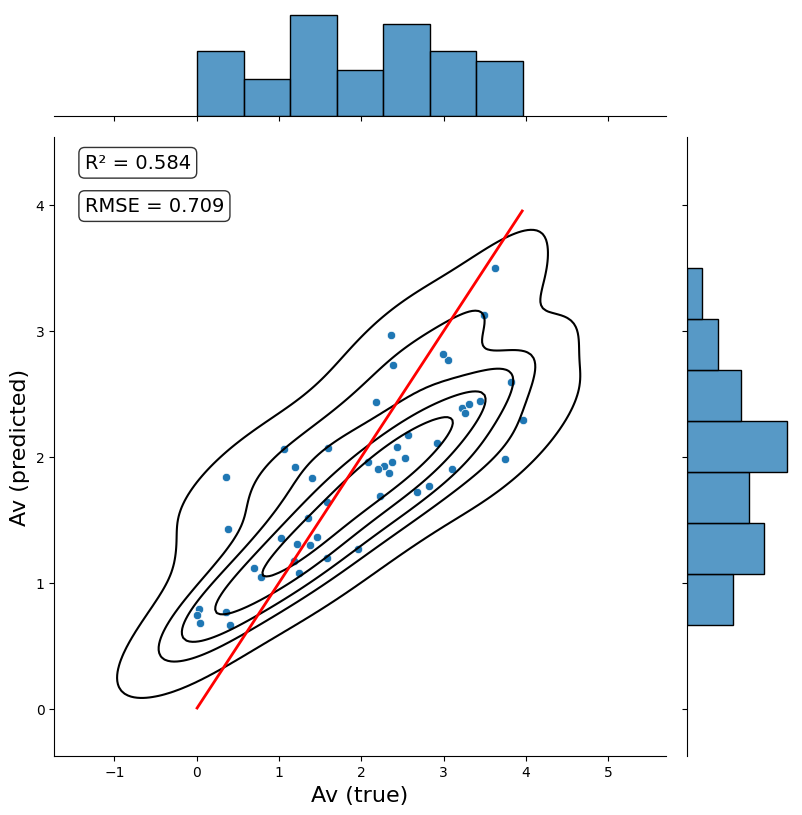

Check the plots above to see how well the model recovers parameters!


In [7]:
# Plot test performance
print("📈 Plotting performance diagnostics...")

from sbipix.plotting import plot_test_performance

plot_test_performance(sx,n_test=50)

print("Check the plots above to see how well the model recovers parameters!")

## Step 6: Load Real JADES Data

Now let's work with real observations from JADES!

In [12]:
# Import the JADES inspector
exec(open('../obs/inspect_jades_hdf5.py').read())

# Initialize inspector for real data
data_file = "../obs/six_galaxies_data.hdf5"

if os.path.exists(data_file):
    inspector = JADESInspector(data_file)
    inspector.print_overview()
    print("\n✅ JADES data loaded successfully!")
else:
    print(f"❌ Data file not found: {data_file}")
    print("Please make sure the JADES data file is in the obs/ directory")

🌌 JADES Galaxy HDF5 Inspector
❌ HDF5 file '--f=/Users/patriglesias/Library/Jupyter/runtime/kernel-v341b3aeabbe61469c4862eb791d085a3c201cc724.json' not found!
🌌 JADES Galaxy HDF5 Data Overview
📁 File: ../obs/six_galaxies_data.hdf5
🔢 Number of galaxies: 6
📐 Coordinate grid: [4500 4500]
📊 Units: μJy | pix
🔍 Galaxy IDs: 117960, 118081, 205449, 206146, 211273, 254985
🔧 Number of filters: 19

📡 Available Filters:
  JWST NIRCam (14 filters):
     1. JWST_NIRCam_F090W
     2. JWST_NIRCam_F115W
     3. JWST_NIRCam_F150W
     4. JWST_NIRCam_F182M
     5. JWST_NIRCam_F200W
     6. JWST_NIRCam_F210M
     7. JWST_NIRCam_F277W
     8. JWST_NIRCam_F335M
     9. JWST_NIRCam_F356W
    10. JWST_NIRCam_F410M
    11. JWST_NIRCam_F430M
    12. JWST_NIRCam_F444W
    13. JWST_NIRCam_F460M
    14. JWST_NIRCam_F480M
  HST ACS (5 filters):
    15. HST_ACS.F435W
    16. HST_ACS.F606W
    17. HST_ACS.F775W
    18. HST_ACS.F814W
    19. HST_ACS.F850LP


✅ JADES data loaded successfully!


In [13]:
# Inspect a specific galaxy
galaxy_id = "205449"  # One of our sample galaxies

print(f"🌟 Inspecting galaxy {galaxy_id}:")
galaxy_data = inspector.inspect_galaxy(galaxy_id)

if galaxy_data:
    print(f"\n📍 Galaxy has {len(galaxy_data['coordinates'])} pixels")
    print(f"📊 Photometry shape: {galaxy_data['photometry'].shape}")

🌟 Inspecting galaxy 205449:
🌟 Galaxy 205449 Details:
  🔴 Redshift: 1.10
  📍 Number of pixels: 20189
  📊 Photometry shape: (20189, 19)
  🎯 Coordinate range: X=[581.0, 788.0], Y=[1723.0, 1898.0]
  📈 Photometry range: [-4.27e-04, 6.79e-02] μJy
  🎲 Non-detection fraction: 0.0%

📍 Galaxy has 20189 pixels
📊 Photometry shape: (20189, 19)


🗺️ Galaxy 205449 spatial distribution:


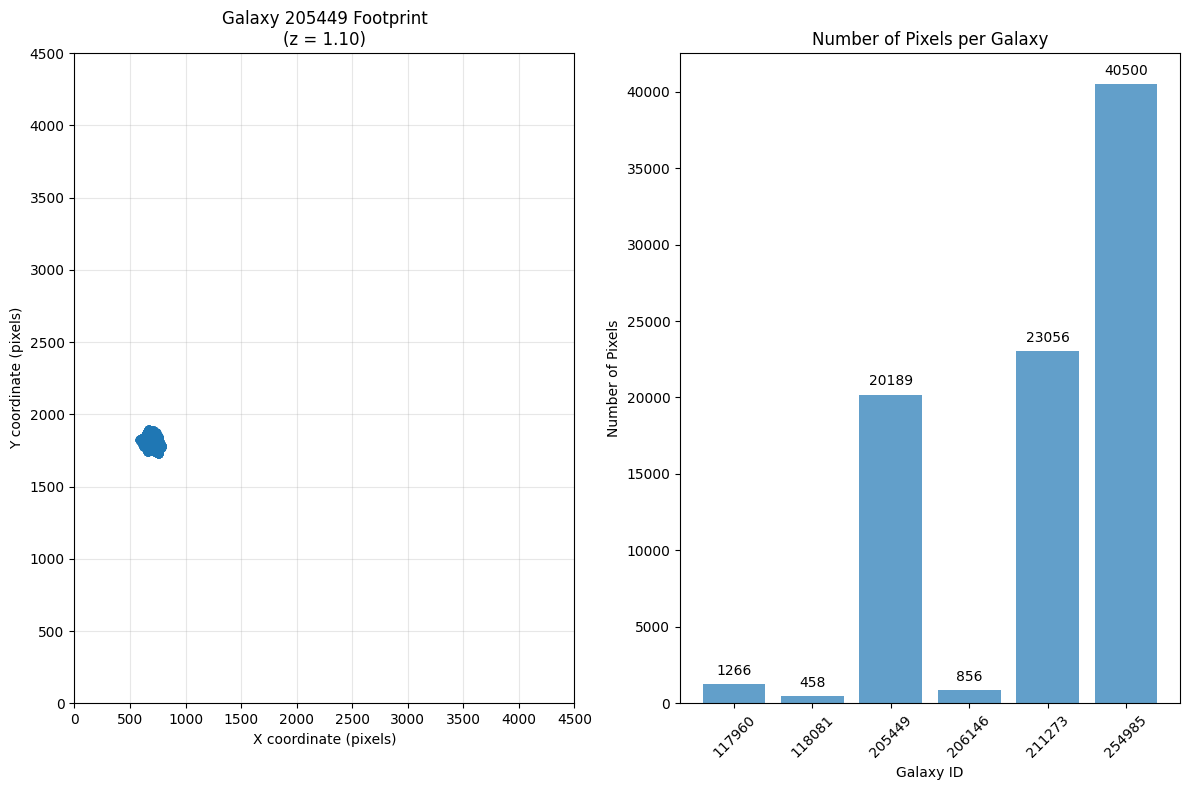

In [14]:
# Plot galaxy footprint
print(f"🗺️ Galaxy {galaxy_id} spatial distribution:")
inspector.plot_galaxy_footprint(galaxy_id)

## Step 7: Run Inference on Real Data

Use our trained model to infer stellar population properties for real galaxies.

In [15]:
# Import inference functions

from inference_six_gal import galaxy_inference

# Run inference on a single galaxy
print(f"🔬 Running inference on galaxy {galaxy_id}...")

try:
    posteriors = galaxy_inference(
        sx,
        int(galaxy_id),
        data=data_file,
        sn_limit=100.0,           # S/N threshold for pixel selection, tipically ~5
        n_samples=500,          # Number of posterior samples
        save_posteriors=True    # Save results to HDF5
    )
    
    if posteriors is not None:
        print("✅ Inference successful!")
        print(f"   - Posterior shape: {posteriors.shape}")
        print(f"   - Fitted {posteriors.shape[0]} pixels")
    else:
        print("❌ Inference failed")
        
except Exception as e:
    print(f"❌ Error during inference: {e}")
    print("This might be due to missing dependencies or data issues")

🔬 Running inference on galaxy 205449...
Galaxy ID: 205449
Filters: ['JWST_NIRCam_F090W', 'JWST_NIRCam_F115W', 'JWST_NIRCam_F150W', 'JWST_NIRCam_F182M', 'JWST_NIRCam_F200W', 'JWST_NIRCam_F210M', 'JWST_NIRCam_F277W', 'JWST_NIRCam_F335M', 'JWST_NIRCam_F356W', 'JWST_NIRCam_F410M', 'JWST_NIRCam_F430M', 'JWST_NIRCam_F444W', 'JWST_NIRCam_F460M', 'JWST_NIRCam_F480M', 'HST_ACS.F435W', 'HST_ACS.F606W', 'HST_ACS.F775W', 'HST_ACS.F814W', 'HST_ACS.F850LP']
Units: μJy | pix
Coordinates grid: [4500 4500]
Redshift: 1.0952999591827393
Using filters for S/N calculation: ['JWST_NIRCam_F277W', 'JWST_NIRCam_F356W', 'JWST_NIRCam_F444W']
Minimum S/N = 100.05
Computing posteriors for 2627 pixels (S/N > 100.0)
Total pixels in galaxy: 20189
Computing resolved posteriors...


100%|██████████| 2627/2627 [01:22<00:00, 31.86it/s]

Saving posteriors to HDF5...
Saved posteriors for 2627 pixels
✅ Inference successful!
   - Posterior shape: (2627, 500, 7)
   - Fitted 2627 pixels


## Step 8: Visualize Results - Parameter Maps

Create beautiful maps showing how stellar properties vary across the galaxy.

🎨 Creating parameter maps for galaxy 205449...
Processing Galaxy ID: 205449
Filters: 19 available
Grid shape: [4500 4500]
Redshift: 1.10
Found posteriors: posterior_tau
Posterior shape: (2627, 500, 7)
Parameters: ['log($M_{*}/\\rm{M}_{\\odot}$)', 'log($M_{*}^{\\rm{formed}}/\\rm{M}_{\\odot}$)', 'log(SFR/($\\rm{M}_{\\odot}$/yr))', '$\\tau$ [Gyr]', '$t_i$ [Gyr]', '[M/H]', 'Av']
Fitted pixels: 2627/20189 (13.01%)


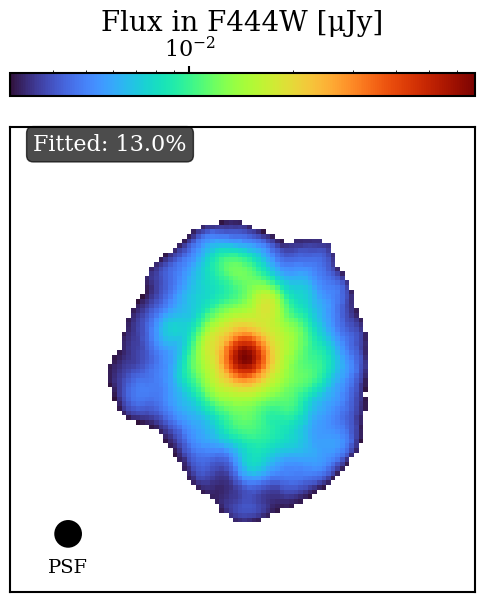

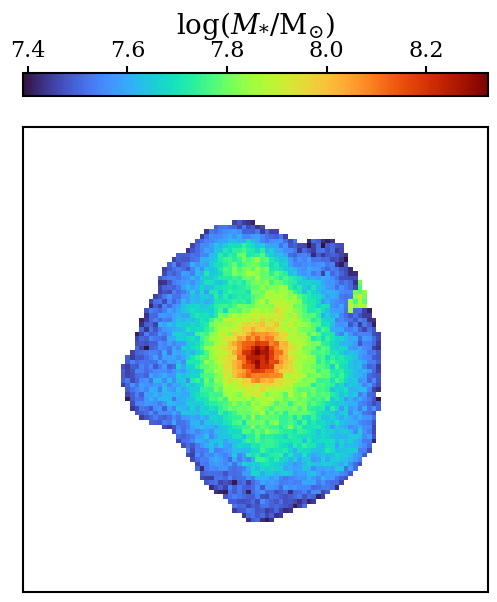

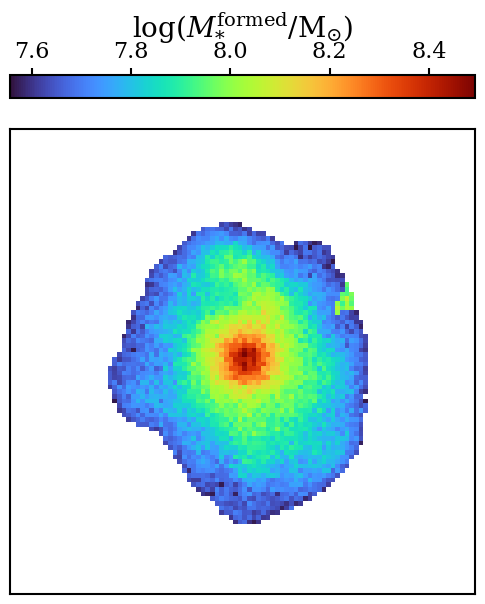

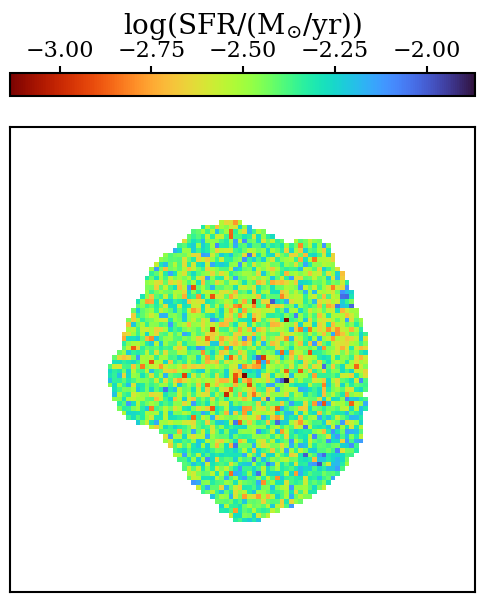

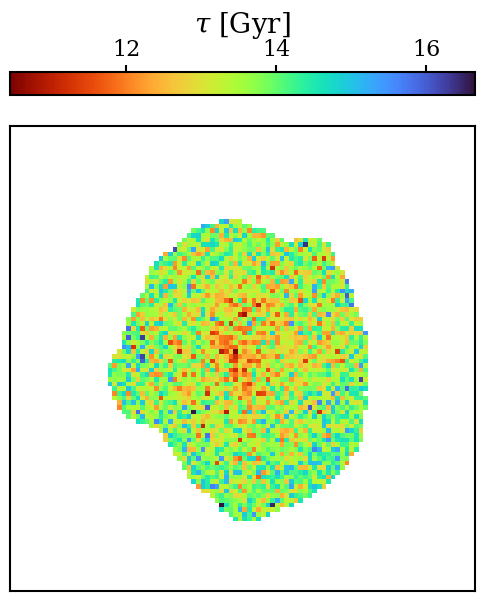

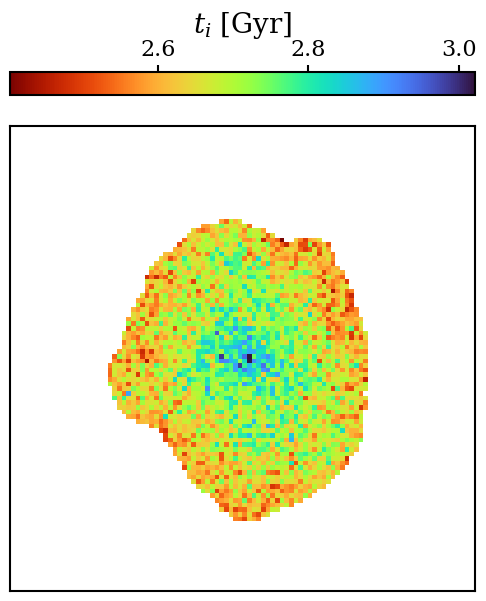

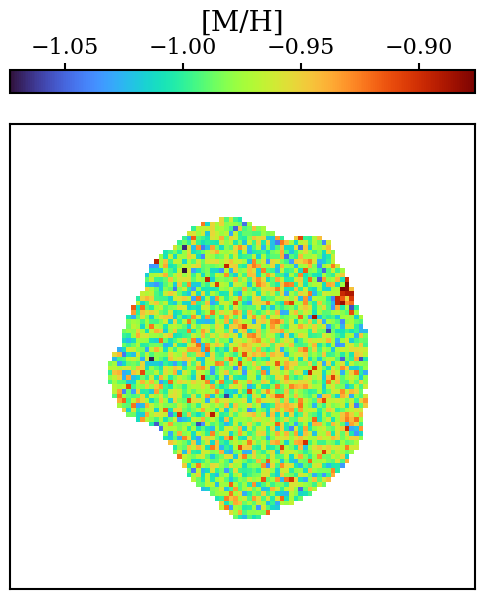

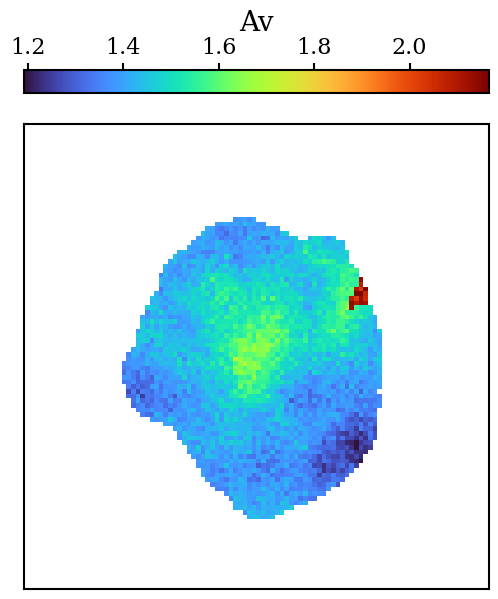

✅ Parameter maps created!


In [16]:
# Import visualization functions
from galaxy_maps import galaxy_maps

# Create parameter maps
print(f"🎨 Creating parameter maps for galaxy {galaxy_id}...")

try:
    galaxy_maps(
        sx=sx,
        galaxy_id=int(galaxy_id),
        data=data_file,
        size=50,                # Plot region size
        plot='maps',            # Create parameter maps
        cmap='turbo',           # Colormap
        plot_fraction=True,     # Show fitted pixel fraction
        metric='mean'           # Use posterior mean
    )
    
    print("✅ Parameter maps created!")
    
except Exception as e:
    print(f"❌ Error creating maps: {e}")
    print("Maps require successful inference results")

📸 Creating error map for galaxy 205449...
Processing Galaxy ID: 205449
Filters: 19 available
Grid shape: [4500 4500]
Redshift: 1.10
Found posteriors: posterior_tau
Posterior shape: (2627, 500, 7)
Parameters: ['log($M_{*}/\\rm{M}_{\\odot}$)', 'log($M_{*}^{\\rm{formed}}/\\rm{M}_{\\odot}$)', 'log(SFR/($\\rm{M}_{\\odot}$/yr))', '$\\tau$ [Gyr]', '$t_i$ [Gyr]', '[M/H]', 'Av']
Error maps - Fitted pixels: 2627/20189 (13.01%)


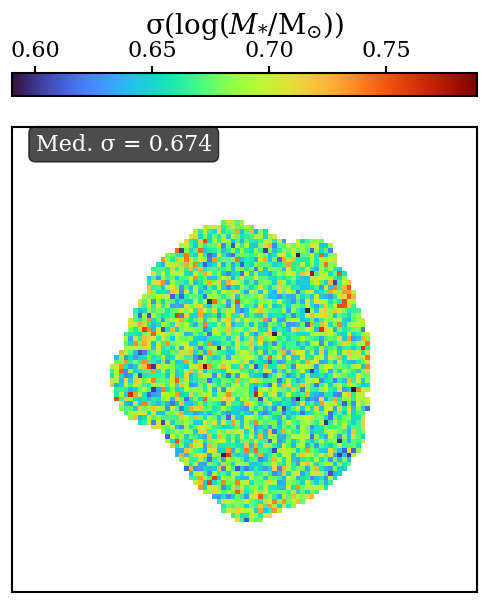

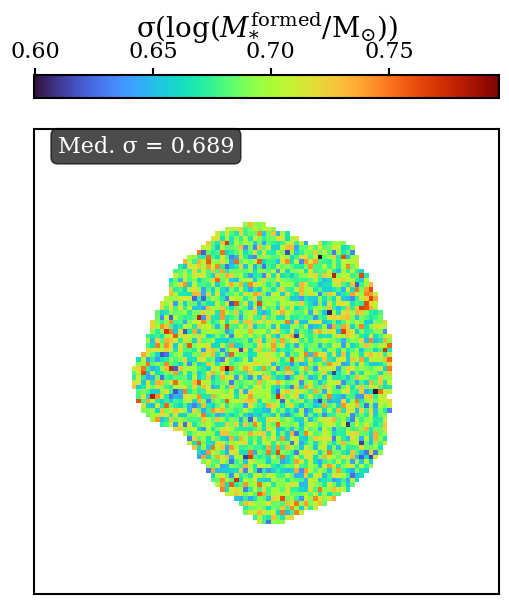

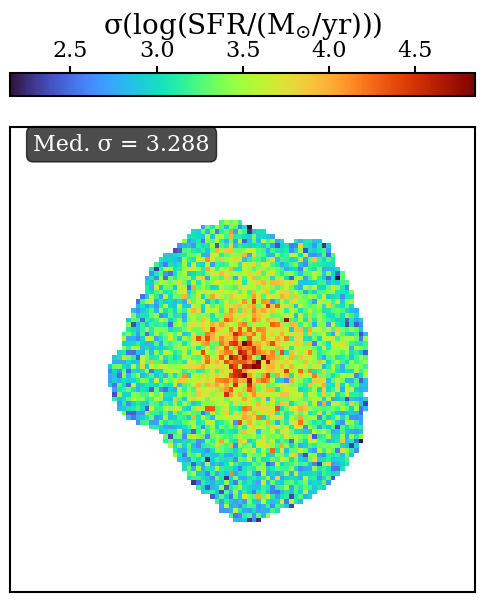

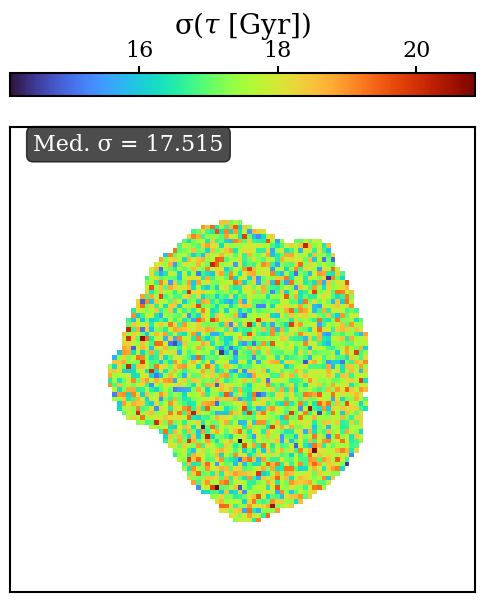

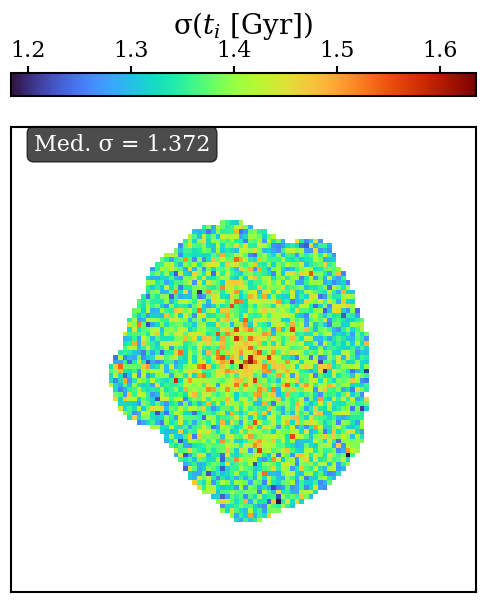

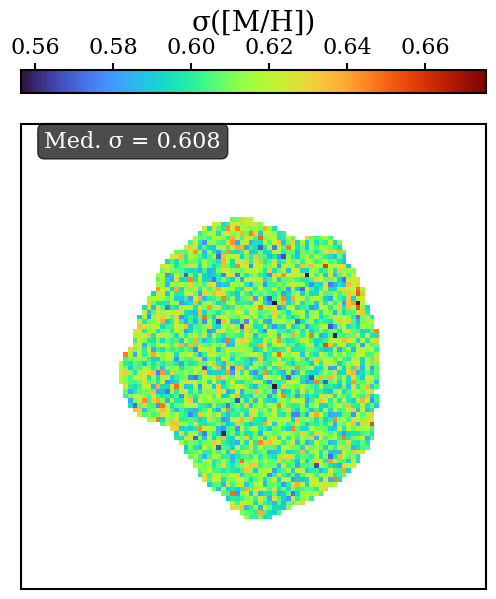

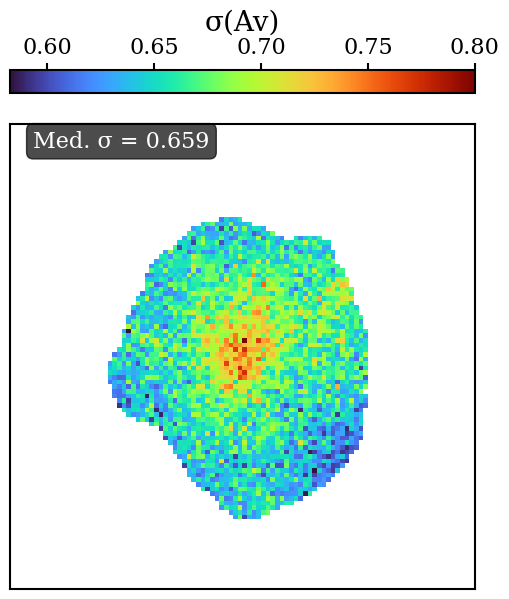

In [17]:
# Also create error maps 
print(f"📸 Creating error map for galaxy {galaxy_id}...")

try:
    galaxy_maps(
        sx=sx,
        galaxy_id=int(galaxy_id),
        data=data_file,
        size=50,
        plot='error_maps',            # Photometry maps
        cmap='turbo',
        all_filters=False       # Just F444W
    )
    
except Exception as e:
    print(f"Note: {e}")

In [16]:
galaxy_id = "205449"  # Reset to the last inspected galaxy

## Step 9: Posterior Predictive Checks

Validate our results by checking how well our model predictions match the observations.

In [16]:
# Initialize FSPS for stellar population synthesis
import fsps
sp = fsps.StellarPopulation(
                    compute_vega_mags=False,
                    zcontinuous=1,
                    sfh=0,  # Simple stellar populations
                    dust_type=2,  # Calzetti dust attenuation
                    imf_type=1,  # Chabrier IMF
                    add_neb_continuum=True,
                    add_neb_emission=True
                )

🔍 Running posterior predictive checks...
Processing 1 galaxies: [205449]
Pixel selections: ['max_snr', 10]

Processing galaxy 205449, selection: max_snr
Selected fitted pixel 10705 (fitted index 1424) with S/N = 462.99


Plotting posterior samples: 100%|██████████| 50/50 [01:54<00:00,  2.29s/it]



Processing galaxy 205449, selection: 10
Selected fitted pixel 5779 (fitted index 10) with S/N = 111.20


Plotting posterior samples:  62%|██████▏   | 31/50 [00:00<00:00, 45.58it/s]

Error processing sample 21: sf_start=5.533207416534424 is greater than tage=5.392246788804946


Plotting posterior samples:  84%|████████▍ | 42/50 [00:00<00:00, 46.60it/s]

Error processing sample 34: sf_start=6.336029052734375 is greater than tage=5.392246788804946


Plotting posterior samples: 100%|██████████| 50/50 [00:01<00:00, 46.25it/s]


Error processing sample 47: sf_start=5.704898357391357 is greater than tage=5.392246788804946


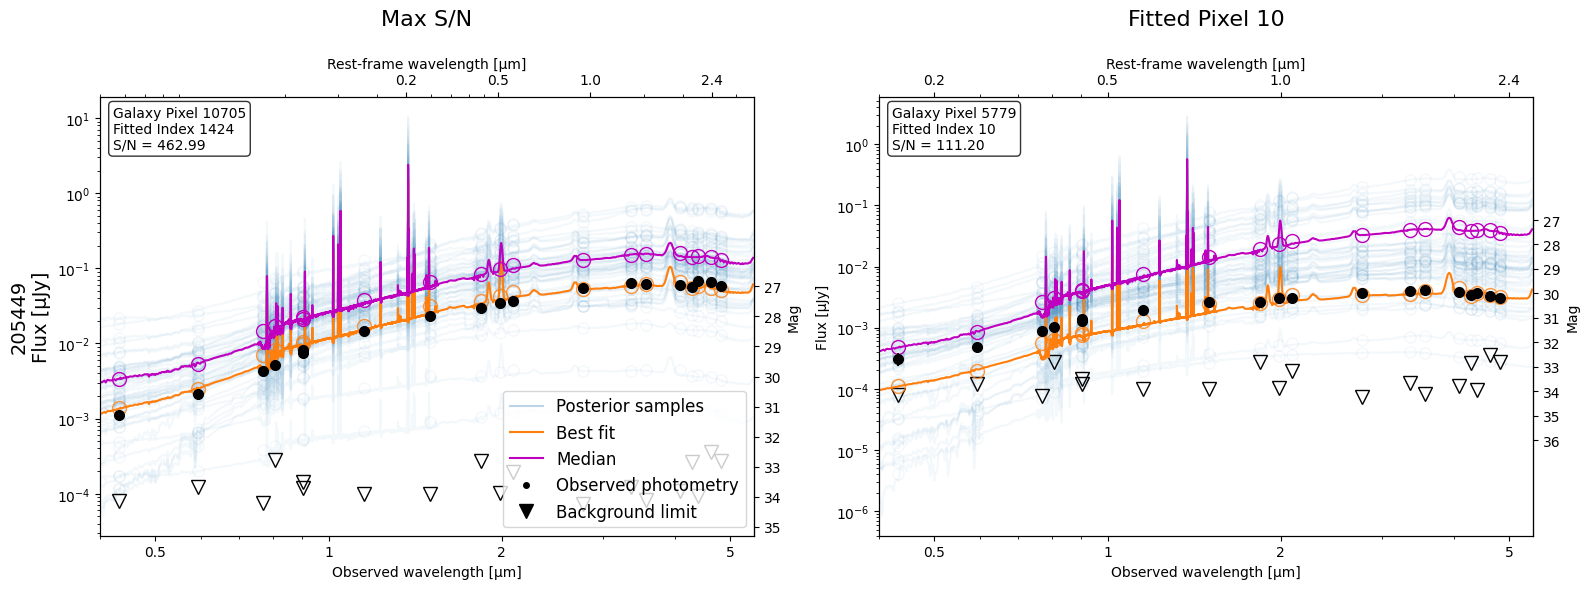

✅ Posterior predictive checks complete!
Check the plots above to see how well our model fits the data


In [17]:
# Import posterior predictive check function
from sbipix.plotting.diagnostics import posterior_predictive_check_sbipix

# Run posterior predictive checks
print("🔍 Running posterior predictive checks...")

try:
    data_file = "../obs/six_galaxies_data.hdf5"
    posterior_predictive_check_sbipix(sx,
        data_file=data_file,
        galaxy_ids=[int(galaxy_id)],    # Just this galaxy
        pixel_selections=['max_snr', 10],  # Compare high S/N vs random pixel
        n_samples=50,                  # Fewer samples for speed
        sp=sp,
        save_fig=False,
        limits_file="../obs/obs_properties/background_noise_hainline.npy",  # Use limits file
        path_obs_properties="../obs/obs_properties/"  # Use properties file
    )
    
    print("✅ Posterior predictive checks complete!")
    print("Check the plots above to see how well our model fits the data")
    
except Exception as e:
    print(f"❌ Error in posterior predictive checks: {e}")
    print("This requires completed inference results")

## Summary

🎉 **Congratulations!** You've completed the SBIPIX tutorial!

### What we accomplished:

1. ✅ **Simulated** 1,000 synthetic galaxy SEDs with realistic parameters
2. ✅ **Added observational effects** like noise and detection limits
3. ✅ **Trained** a normalizing flow model for rapid Bayesian inference
4. ✅ **Tested** model performance on synthetic data
5. ✅ **Loaded** real JADES observations
6. ✅ **Ran inference** on individual galaxy pixels
7. ✅ **Created** beautiful parameter maps
8. ✅ **Validated** results with posterior predictive checks

### Next steps:

- **Scale up**: Increase `n_simulation` for better accuracy
- **Explore more galaxies**: Process the full sample of 6 galaxies
- **Try non-parametric models**: Set `sx.parametric = False`
- **Advanced analysis**: Compare different star formation histories
- **Custom data**: Apply SBIPIX to your own observations

### Troubleshooting:

If you encountered errors:
- Make sure all dependencies are installed
- Check that data files exist in the correct locations
- Try smaller `n_simulation` values for faster testing
- Consult the documentation for advanced usage

Happy inferring! 🌌✨

In [46]:
# Final summary
print("🌟 SBIPIX Tutorial Complete! 🌟")
print("\nYou now know how to:")
print("  🔬 Simulate and train SBIPIX models")
print("  📊 Analyze real JADES data")
print("  🎨 Create stunning visualizations")
print("  ✅ Validate your results")
print("\nKeep exploring the universe, one pixel at a time! 🚀")

🌟 SBIPIX Tutorial Complete! 🌟

You now know how to:
  🔬 Simulate and train SBIPIX models
  📊 Analyze real JADES data
  🎨 Create stunning visualizations
  ✅ Validate your results

Keep exploring the universe, one pixel at a time! 🚀
